In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.integrate import simps


from CryoModel.radmodel import uprint

In [6]:
#constants
#Stefan-Boltzmann constant
SIGMA = 5.6704E-12   #[J/s*cm^2*K^4]


class ThermalMaterial:
    def __init__(self, name, specificHeat=np.inf, conductivity=np.inf, latentHeat=np.inf ):
        self.name = name
        self.specificHeat = specificHeat
        self.conductivity = conductivity
        self.latentHeat = latentHeat 
        
    def getFlux(self,T1,T2,AOverL):
        
        Ts = self.conductivity[:,0]
        ks = self.conductivity[:,1]
        
        dT = np.min(Ts[1:] - Ts[:-1])
        T  = np.arange(T1, T2, dT)
        
        return AOverL * simps(np.interp(T, Ts, ks), T)

SShigh = np.loadtxt('./cryoModel/thermalProp/ss304_cv.txt',)
SST    = np.arange(.2,3.9,0.1)
SSlow  = np.stack((SST, 0.0556*SST**1.15)).T


SS = ThermalMaterial(name='SS304', conductivity=np.concatenate((SSlow,SShigh)))
CF = ThermalMaterial(name='CF', conductivity=np.loadtxt('./cryoModel/thermalProp/CF_cv.txt',))
G10 = ThermalMaterial(name='G10', conductivity=np.loadtxt('./cryoModel/thermalProp/g10_cv_combined.txt',))
    
        
class ThermalLink(object):
    def __init__(self, name, s1, s2,):
        self.name = name
        self.s1   = s1
        self.s2   = s2

class Radi(ThermalLink):
    def __init__(self, area=0, **kwargs):
        super().__init__(**kwargs)
        self.type = 'Radiation'
        self.area = area 
        
    def calFlux(self):
        self.flux = self.area * SIGMA * (self.s1.T**4 - self.s2.T**4)
        self.s1.load -= self.flux
        self.s2.load += self.flux
        
        return self.flux
        
class Cond(ThermalLink):
    def __init__(self, AOverL=0, material=None, **kwargs):
        super().__init__(**kwargs)
        self.type = 'Conduction'
        self.AOverL = AOverL
        self.material = material
        
    def calFlux(self):
            
        self.flux = self.material.getFlux(self.s2.T, self.s1.T, self.AOverL)
        self.s1.load -= self.flux
        self.s2.load += self.flux
        
        return self.flux
        
class Fridge(ThermalLink):
    def __init__(self, stp = 8, heaterE=5000, no_load_time=72*3600, **kwargs):
        super().__init__(**kwargs)
        self.type = 'Fridge'
        self.coldE = stp/22.4*25 # in J
        self.heaterE = heaterE   # in J
        self.no_load_time = no_load_time  # in seconds
        self.para_load = self.coldE/no_load_time  # in W
        
    def getLoad(self):
        load = self.s2.load + self.para_load
        self.hold_time = self.coldE/ load

    def calFlux(self):
        self.getLoad()
        self.flux = self.s2.load + self.para_load + self.heaterE/self.hold_time
        self.s1.load += self.flux
        
class Stages(object):
    def __init__(self, name, T0, Type=None):
        self.name = name
        self.T    = float(T0)
        self.Type = Type
        self.load = 0.
        
        
class ThermalSystem(object):
    
    ### setting up the model
    def __init__(self, name,):
        self.name = name
        self.stages = []
        self.linkages = []
        
    def add_stage(self, stage):
        self.stages.append(stage)
        
    def add_stages(self, stages):
        for stage in stages:
            self.stages.append(stage)
        
    def add_linkage(self, link):
        self.linkages.append(link)
         
    ### print the details of the model          
    def showLinks(self,):
        print('Linkages:')
        for link in self.linkages:
            print('  %s\t'%link.name,'| from %s to %s\t'%(link.s1.name, link.s2.name), '|', link.type)
            
    def showStages(self,):
        print('Stages:')
        for stage in self.stages:
            print('  ', stage.name,', Temp:', stage.T)
    
    def showSystem(self):
        print('System:', self.name)
        self.showStages()
        self.showLinks()
        
    def showLoads(self):
        print('Fluxs on links:')
        for link in self.linkages:
            print('  Link: %10s\t'%link.name,' Flux: ', uprint(link.flux, fmt='%6.3f') )
        print('Loads on stages:')
        for stage in self.stages:
            print('  Stage: %s\t'%stage.name,' Load: ', uprint(stage.load, fmt='%6.3f') )
         
        
    def showFridge(self):
        print('Fridge:')
        for link in self.linkages:
            if link.type == 'Fridge':
                print('  Link: %10s\t'%link.name,' Avg MT Load: ', uprint(link.flux, fmt='%6.3f'),\
                     '')
                print('  Hold Time: %2.2f h\t'%(link.hold_time/3600), 'Cycle Efficiency: %2.2f \t'%(1 - 2*3600/link.hold_time))
                print('  Outside Load: ', uprint(link.s2.load, fmt='%4.2f'), 'Parasitic Load: ', uprint(link.para_load, fmt='%4.2f') )

                
    ### methods
    def calLoads(self):
        for stage in self.stages:
            stage.load = 0
        for link in self.linkages:
            flux = link.calFlux()

        

In [4]:
model = ThermalSystem(name='TIM subKelvin system')
stages = [Stages(name='4k', T0=4.2), Stages(name='1k', T0=.9), \
          Stages(name='0.3k', T0=.25)]

model.add_stages(stages)

# radiation
model.add_linkage(Radi(name='Rad_4k_1k', area = 100, s1=model.stages[0], \
                            s2=model.stages[1]))
model.add_linkage(Radi(name='Rad_4k_03k', area = 1200, s1=model.stages[0], \
                            s2=model.stages[2]))


# carbon fiber rods
CF_AL = 16 * np.pi *(2.5e-3**2-1.5e-3**2)/0.15
model.add_linkage(Cond(name='CF_rod_4k_1k', AOverL = CF_AL, material=CF, s1=model.stages[0], \
                            s2=model.stages[1]))

CF_AL2 = 16 * np.pi *(2.5e-3**2-1.e-3**2)/0.1
model.add_linkage(Cond(name='CF_rod_1k_03k', AOverL = CF_AL2, material=CF, s1=model.stages[1], \
                            s2=model.stages[2]))


# model.add_linkage(Cond(name='HS_4k_1k', AOverL = 2e-5, material='SS', s1=model.stages[0], \
#                             s2=model.stages[1]))


Wire_AOverL = (8*2+2) * np.pi*(6.5e-4**2-5e-4**2)/0.2
model.add_linkage(Cond(name='Wire_4k_1k', AOverL = Wire_AOverL, material=SS, s1=model.stages[0], \
                            s2=model.stages[1]))

Wire_AOverL2 = (8*2+2) * np.pi*(6.5e-4**2-5e-4**2)/0.1
model.add_linkage(Cond(name='Wire_1k_03k', AOverL = Wire_AOverL2, material=SS, s1=model.stages[1], \
                            s2=model.stages[2]))




# fridge
model.add_linkage(Fridge(name='He3_4k_03k', s1=model.stages[0], s2=model.stages[2], \
                        stp = 8, heaterE=4600, no_load_time=72*3600))


model.showSystem()

System: TIM subKelvin system
Stages:
   4k , Temp: 4.2
   1k , Temp: 0.9
   0.3k , Temp: 0.25
Linkages:
  Rad_4k_1k	 | from 4k to 1k	 | Radiation
  Rad_4k_03k	 | from 4k to 0.3k	 | Radiation
  CF_rod_4k_1k	 | from 4k to 1k	 | Conduction
  CF_rod_1k_03k	 | from 1k to 0.3k	 | Conduction
  Wire_4k_1k	 | from 4k to 1k	 | Conduction
  Wire_1k_03k	 | from 1k to 0.3k	 | Conduction
  He3_4k_03k	 | from 4k to 0.3k	 | Fridge


In [5]:
model.calLoads()
model.showLoads()
model.showFridge()

Fluxs on links:
  Link:  Rad_4k_1k	  Flux:  176.074 nW
  Link: Rad_4k_03k	  Flux:   2.117 uW
  Link: CF_rod_4k_1k	  Flux:  79.826 uW
  Link: CF_rod_1k_03k	  Flux:   7.491 uW
  Link: Wire_4k_1k	  Flux:  26.637 uW
  Link: Wire_1k_03k	  Flux:   1.652 uW
  Link: He3_4k_03k	  Flux:  23.594 mW
Loads on stages:
  Stage: 4k	  Load:  23.485 mW
  Stage: 1k	  Load:  97.496 uW
  Stage: 0.3k	  Load:  11.260 uW
Fridge:
  Link: He3_4k_03k	  Avg MT Load:  23.594 mW 
  Hold Time: 54.26 h	 Cycle Efficiency: 0.96 	
  Outside Load:  11.26 uW Parasitic Load:  34.45 uW


In [88]:
model.linkages[-1].hold_time/3600


53.98775463747813

In [12]:
T = 5.67e-8 * 1 * 4**4 
T/(84.5/0.004)*86400*20

0.0011873261822485206

In [12]:
load = 25*1e-3

L = 20.9 # J/g
rho = 125 #g/L

rate = 86400*load/(L*rho)

print(rate)
print(250/rate)

0.8267942583732057
302.37268518518516


12.203483253588516

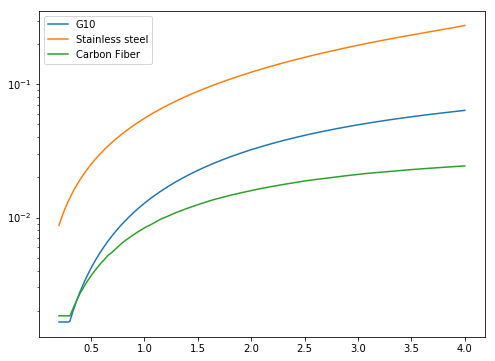

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

T = np.linspace(0.2, 4, 300)

G10_func = np.interp(T, T_G10, k_G10)
SS_func = np.interp(T, T_SS, k_SS)
CF_func = np.interp(T, T_CF, k_CF)

plt.plot(T, G10_func, label= 'G10')
plt.plot(T, SS_func, label= 'Stainless steel')
plt.plot(T, CF_func, label= 'Carbon Fiber')

plt.yscale('log')

plt.legend()